In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd

In [29]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [30]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [31]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [32]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [33]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [36]:
# Latest Date in DataFrame

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

latest_date

('2017-08-23',)

In [46]:
# Calculate the date 1 year ago from the last data point in the database

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

one_year_ago

datetime.date(2016, 8, 23)

In [47]:
# Perform a query to retrieve the data and precipitation scores

precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

precipitation_data


[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [53]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipitation_data, columns=["Date","Precipitation"])
precipitation_df.set_index("Date", inplace=True,)


precipitation_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


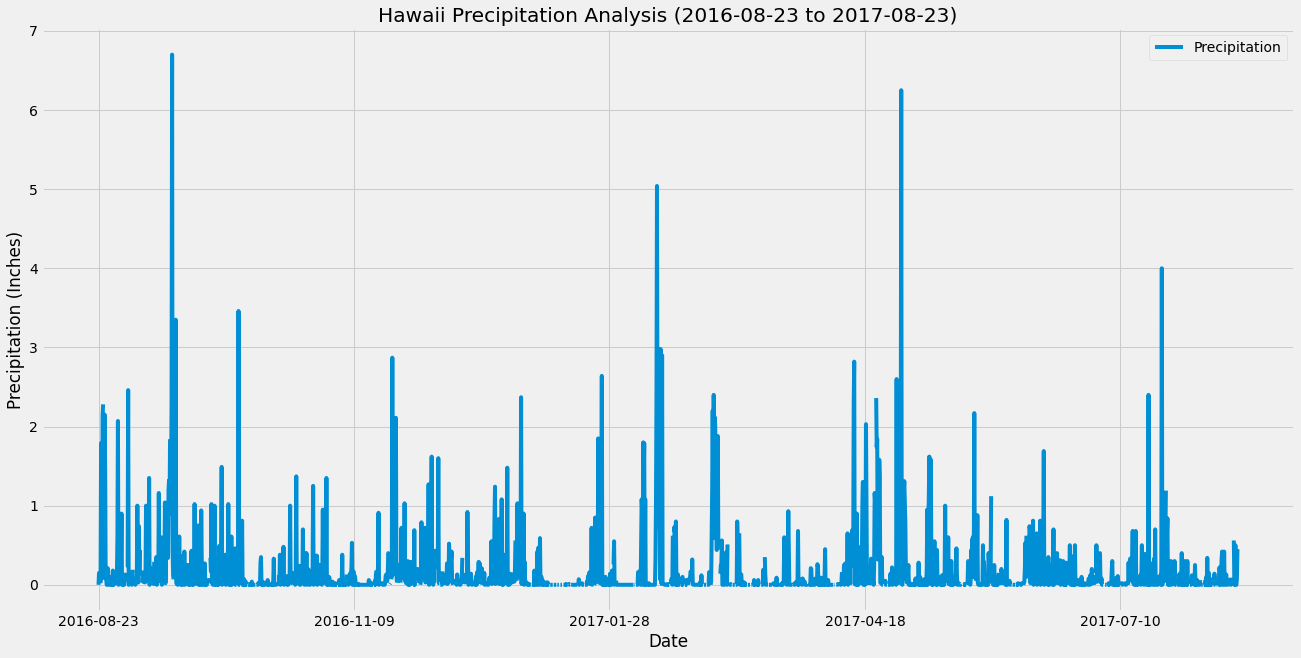

In [60]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(title="Hawaii Precipitation Analysis (2016-08-23 to 2017-08-23)", figsize=(20,10))
plt.legend(loc='upper right')
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

plt.show()

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [62]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Measurement.station).distinct().count()

stations

9

In [63]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = 'USC00519281'

temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

temperatures

[(54.0, 85.0, 71.66378066378067)]

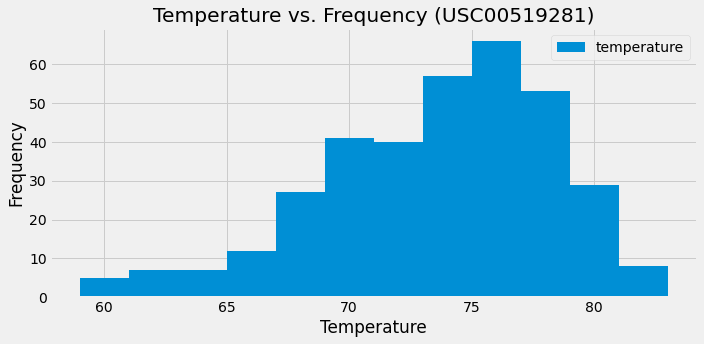

In [68]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

temp_observation_df.plot.hist(bins=12, title="Temperature vs. Frequency (USC00519281)", figsize=(10,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()